In [1]:
# # import all relevant libraries dependencies and set up the backend
# import time
# import IPython
# import numpy as np
# import matplotlib
# import math
# import pandas
# import pickle
# import subprocess
# import matplotlib.pyplot as plt
# %matplotlib inline

# import scipy
# import scipy.special 
# import scipy.optimize
# import scipy.sparse.linalg as LA
# import scipy.sparse as sparse
# from scipy.io import loadmat
# from scipy.optimize import curve_fit
# from scipy.signal import argrelextrema

# # add the ED.py functions to the notebook
# import sys
# #import hubbard as ED 

# from matplotlib import animation, rc
# # rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':12})
# # rc('font',**{'family':'serif','serif':['FreeSerif'],'size':12})
# rc('text', usetex=True)
# from cycler import cycler

# c1_a = '#003AF0'
# c2_a = '#008F24'
# c3_a = '#FE7B22'
# c4_a = '#FE000C'
# c5_a = '#FB30F2'
# c6_a = '#82E0AA' #'#FFE135'
# c7_a = '#9966CC'
# c8_a = '#7FFFD4'
# c9_a = '#66FF00'
# c10_a = '#8B008B'
# c11_a = '#000000'
# colours = [c1_a,c2_a,c3_a,c4_a,c5_a,c6_a,c7_a,c8_a,c9_a,c10_a,c11_a]

# matplotlib.rcParams['backend']='MacOSX'
# matplotlib.rcParams['savefig.dpi']=250
# matplotlib.rcParams['text.usetex']=True
# # matplotlib.rcParams['text.latex.unicode']=True
# matplotlib.rcParams['axes.prop_cycle'] = cycler('color',colours)
# # matplotlib.rcParams['axes.'] = \in\
# # matplotlib.rcParams['legend.fancybox']=True
# matplotlib.rcParams['legend.frameon']=False
# # matplotlib.rcParams['legend.fontsize']=10
# matplotlib.rcParams['figure.figsize'] = (10,8)
# # matplotlib.rcParams['axes.color_cycle'] = colors
# # matplotlib.rcParams['axes.prop_cycle'] = colors

In [142]:
import numpy as np
import scipy
import scipy.special
import scipy.sparse.linalg as LA
import scipy.sparse as sparse
import copy
import warnings
import matplotlib.pyplot as plt


def state_to_int(p, statelist):
    """
    Converts array of spin-configuration into integer
    Args:
        p - dictionary that contains the relevant system parameters
        statelist - spin configuration (binary)
    Returns:
        out - integer corresponding to state
    """
    # convert statelist to string
    state = ''.join([str(s) for s in statelist])
    # construct unique integer for the fermion configuration defined
    # in statelist
    out = int(state,2)
    return out


def int_to_state(p, state_number):
    """
    Converts integer to array of spin-configuration
    Args:
        p - dictionary that contains the relevant system parameters
        state_number - integer corresponding to state
    Returns:
        statelist - fermion configuration
    """

    # convert integer to spin configuration of length L (binary representation)
    statelist = format(state_number,"0%sb"%(p['N']))
    # remove the 0b tag at the beginning
    statelist = [int(s) for s in statelist]
    return statelist


def generate_state_table(p):
    """
    generates table of state-integers of the full Hilbertspace
    Args:
        p - dictionary that contains the relevant system parameters
    Returns:
        state_table - list of all state_numbers that belong to the Hilbertspace
    """
    # generate list of state_numbers which are allowed by the symmetries
    state_table = []
    for i in range(int(2**p['N'])):
        state_table.append(i)
    return state_table


def transverse_field_matrix(p, state_table):
    """
    generates the full transverse field interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        transverse_field - interaction matrix on the Hilbertspace
    """
    
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])

        # iterate through the chain and flip each spin with application of X
        for i in range(len(state)):
            outstate = copy.deepcopy(state)
            
            # flip local spin (X)
            outstate[i] = 0 if outstate[i] else 1
            
            # get new state number
            Out = state_to_int(p, outstate)
            
            # get matrix element (note Sx = 1/2*X)
            matrixelement = -0.5 * p['hx']
            
            # store matrix element
            row.append(Out)
            col.append(In)
            data.append(matrixelement)
            
            del matrixelement

    transverse_field = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return transverse_field


def longitudinal_field_matrix(p, state_table):
    """
    generates the full longitudinal field interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        longitudinal_field - interaction matrix on the Hilbertspace
    """
        
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        # eigenvalue of |0> is -1/2 and |1> is 1/2 so transform state (binary code) to spin basis
        spin = state - 0.5

        # get matrix element
        matrixelement = -1.0 * p['hz'] * np.sum(spin)
            
        # store matrix element (note hz is diagonal so Out = In)
        row.append(In)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    longitudinal_field = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return longitudinal_field


def ZZinteraction_matrix(p, state_table):
    """
    generates the full ZZ interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        ZZ_interaction - ZZ interaction matrix on the Hilbertspace
    """
    
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        # eigenvalue of |0> is -1/2 and |1> is 1/2 so transform state (binary code) to spin basis
        spin = np.asarray(state) - 0.5
            
        # multiply nearest neighbour ZZ interaction term
        ZiZj = spin[1:] * spin[:-1]
        
        # get matrix element
        matrixelement = -1.0 * p['Jz'] * np.sum(ZiZj)
            
        # store matrix element (note hz is diagonal so Out = In)
        row.append(In)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement, ZiZj
        
    ZZ_interaction = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return ZZ_interaction


def spinflip_matrix(p, state_table):
    """
    generates the full 0.5*(S(i,+)S(i+1,-) + S(i,-)S(i+1,+)) interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        spinflip_interaction - spinflip interaction matrix on the Hilbertspace
    """
    
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])

        # iterate through the chain and swap adjacent spins if they are anti-alligned
        for i in range(len(state)-1):
            if state[i] != state[i+1]:
                outstate = copy.deepcopy(state)

                # swap spins and sites (i,i+1)
                outstate[i] = 0 if outstate[i] else 1
                outstate[i+1] = 0 if outstate[i+1] else 1

                # get new state number
                Out = state_to_int(p, outstate)

                # get matrix element
                matrixelement = -0.5 * p['Jx']

                # store matrix element
                row.append(Out)
                col.append(In)
                data.append(matrixelement)

                del matrixelement
        
    spinflip_interaction = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return spinflip_interaction


def make_Hamiltonian(p, state_table):
    """
    Generates full Hamiltonian on the full Hilbertspace
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the Hilbertspace
    Returns:
        H - Hamiltonian matrix on the full Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    H = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    # H = transverse_field_matrix(p, state_table)
    # H += longitudinal_field_matrix(p, state_table)
    H += spinflip_matrix(p, state_table)
    H += ZZinteraction_matrix(p, state_table)

    return H


def calculate_gs(p):
    """
    calculates groundstate of full Hamiltonian on the full Hilbertspace
    Args:
        p - dictionary that contains the relevant system parameters for the GS search
    Returns:
        E0 - GS energy
        gs - GS vector on the relevant Hilbertspace subspace
        state_table - list of all state_numbers that belong to the full Hilbertspace
    """
    state_table = generate_state_table(p)
    H = make_Hamiltonian(p, state_table)
    w, v = scipy.sparse.linalg.eigsh(H, k=1, which='SA')

    return w[0], v[:, 0], state_table


def expct_val(Op, psi):
    """
    compute expecation value of operator 'Op' with state 'psi'
    Args:
        Op - operator corresponding to observable to be measured
        psi - state-vector (on sub-Hilbertspace)
    Returns:
        <psi| Op |psi>
    """
    return (psi.conj().T).dot(Op.dot(psi))


def matrix_elements(Op, bra, ket):
    """
    compute matrix element of operator 'Op' with state 'bra' form the left and 'ket' from the right
    Args:
        Op - operator corresponding to observable to be measured
        bra - adjoint (left/outgoing) state
        ket - (right/incoming) state
    Returns:
        <bra| Op |ket>
    """
    return (bra.conj().T).dot(Op.dot(ket))


def Sz_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator Sz_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which Sz is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Sz - Sz_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        # eigenvalue of |0> is -1/2 and |1> is 1/2 so transform state (binary code) to spin basis
        spin = np.asarray(state) - 0.5

        matrixelement = spin[site]
        # store matrix element
        if matrixelement != 0.0:
            row.append(In)
            col.append(In)
            data.append(matrixelement)

        del matrixelement

    Sz = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Sz


def Sx_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator Sx_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which Sx is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Sx - Sx_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
            
        # flip local spin (Sx = 1/2*X) at site 
        outstate[site] = 0 if outstate[site] else 1
            
        # get new state number
        Out = state_to_int(p, outstate)
            
        # get matrix element
        matrixelement = 0.5
            
        # store matrix element
        row.append(Out)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    Sx = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Sx


def Sy_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator Sy_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which Sy is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Sy - Sy_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
            
        # flip local spin (Sy = 1/2*Y) at site 
        outstate[site] = 0 if outstate[site] else 1
            
        # get new state number
        Out = state_to_int(p, outstate)
            
        # get matrix element (-i if initially state = 0 else i)
        matrixelement = 1.j if state[site] else -1.j
            
        # store matrix element
        row.append(Out)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    Sy = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Sy


def Sp_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator S+_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which S+ is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Splus - S+_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
        
        if not(outstate[state]):
            # raise local spin (S+ = Sx + i Sy) at site
            outstate[site] = 1

            # get new state number
            Out = state_to_int(p, outstate)

            # get matrix element
            matrixelement = 1.0

            # store matrix element
            row.append(Out)
            col.append(In)
            data.append(matrixelement)

            del matrixelement
        
    Splus = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Splus


def Sm_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator S-_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which S- is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the full Hilbertspace
    Returns:
        Sminus - S-_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
        
        if outstate[state]:
            # lower local spin (S- = Sx - i Sy) at site
            outstate[site] = 0

            # get new state number
            Out = state_to_int(p, outstate)

            # get matrix element
            matrixelement = 1.0

            # store matrix element
            row.append(Out)
            col.append(In)
            data.append(matrixelement)

            del matrixelement
        
    Sminus = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Sminus


def build_densitymatrix(psi):
    """
    build the density matrix from a pure state psi
    Args:
        psi - state-vector (on full Hilbertspace)
    Returns:
        rho = |psi><psi|
    """
    
    # reshape psi0 into vector form of dimension (dim,1)
    psi = np.reshape(psi, (len(psi),1))
    
    return psi.dot(psi.conj().T)


def purification(rho):
    """
    purify the density matrix into vector form
    Args:
        rho - density matrix (on  full Hilbertspace)
    Returns:
        rho_vec = |psi>|psi>
    """

    return rho.flatten(order='C')


def depurification(rho_vec):
    """
    depurify the density matrix vector back into density matrix shape
    Args:
        rho_vec - density matrix vector (on  full Hilbertspace)
    Returns:
        rho = |psi><psi|
    """
    
    # dimension of Hilbert space is sqrt of the vector size
    dim = int(np.sqrt(np.size(rho_vec)))
    return rho_vec.reshape(dim,dim)


def quantum_fisher_info(rho, op, tol=1e-20):
    """
    compute the Quantum Fisher Information for operator op and density matrix rho
    Args:
        rho - density matrix (either in standard or purified form)
        op - measurement operator on the full Hilbert space
        tol - tolerance to check the purity of the density matrix and which eigenvalues to sum in the QFI
    Returns:
        QFI - Quantum Fisher Information
        purity - Purity of the density matrix. If purity=-1 we use the full QFI computation, 
                    else the variance for pure state
    """
    
    # if rho is in purified form, bring it to standard form
    if np.size(rho) == np.shape(rho)[0]:
        rho = depurification(rho)
    
    # check if rho is truly a square hermitian matrix with trace 1
    try:
        np.shape(rho)[0] == np.shape(rho)[1] and np.allclose(rho.conj().T, rho, rtol=0.0, atol=tol) and \
            np.trace(rho) == 1.0
    except AsymmetricMatrixError:
        print("Not a square density matrix")
    
    # compute the quantum fisher information
    QFI = 0.
    
    # check if rho is describing a pure state i.e. its purity:
    if np.allclose(rho.dot(rho), rho, rtol=0.0, atol=tol):
        # rho described a pure state so QFI = 4 * Var(op) = 4 * (<op^2> - <op>^2)
        QFI = 4 * (np.trace(rho.dot(op.dot(op))) - np.trace(rho.dot(op))**2)
        purity = np.trace(rho.dot(rho))
    else:
        # rho described a mixed state
        purity = -1
        
        # diagonalise rho and get eigenvalues and right eigenvectors
        Eval, rEvec = scipy.linalg.eig(rho, right=True)
        for i in range(len(Eval)):
            for j in range(len(Eval)):
                if Eval[i] + Eval[j] > tol:
                    # only sum over at least on non-zero eigenvalue
                    prefactor = 2 * (Eval[i] - Eval[j])**2 / (Eval[i] + Eval[j])
                    QFI += prefactor * np.abs(matrix_elements(op, rEvec[:,i], rEvec[:,j]))**2
                else:
                    continue

    return QFI, purity


def build_LindbladMatrix(p):
    """
    build Lindblad matrix acting on purified density matrix
    Args:
        p - dictionary that contains the relevant system parameters
    Returns:
        L - Lindblad matrix on the (full * auxiliary) state space
    """

    # set up basis states and Hilbert space
    state_table = generate_state_table(p)
    dim = len(state_table)
    I = sparse.csr_matrix(np.eye(dim))
    
    # make Hamiltonian
    H = make_Hamiltonian(p, state_table)
    
    # make jump operators
    jump_op = {}
    for i in range(p['N']):
        # Sz
        jump_op['Sz(%s)' % (i)] = Sz_matrix(p, i, state_table)
        # Splus
        # jump_op['Sp(%s)' % (i)] = Sp_matrix(p, i, state_table)
        # Sminus
        # jump_op['Sm(%s)' % (i)] = Sm_matrix(p, i, state_table)
    
    # build L
    L = -1j * sparse.kron(H, I) + 1j * sparse.kron(I, H.T)
    
    for op in jump_op:
        L += p['gamma_%s' % op[:2]] * sparse.kron(jump_op[op], (jump_op[op].conj().T).T)
        L += -0.5 * p['gamma_%s' % op[:2]] * sparse.kron((jump_op[op].conj().T).dot(jump_op[op]), I)
        L += -0.5 * p['gamma_%s' % op[:2]] * sparse.kron(I, ((jump_op[op].conj().T).dot(jump_op[op])).T)
        
    return L


def evolve(p, state_table, rho, kind="matrix"):
    """
    evolve purified density matrix 'rho' under parameters defined in dictionary 'p'
    Args:
        p - dictionary that contains the relevant system parameters for time-evolution
        state_table - list of all basis states (int) in the full Hilbert space
        rho - initial density matrix in purified form
        kind - how the state is passed to the function: 
                kind=list spin-configuration (productstate) OR 
                kind="int" the unique state id in the state_table OR
                kind="matrix" (default) regular density matrix OR 
                kind="purified" the purified density matrix vector
    Returns:
        sim - dictionary with the relevant measurements: Sx, Sy, Sz, FI
        state_table - list of all state_numbers that belong to the full Hilbertspace
    """
    
    if kind == "list":
        # if we parsed a product state, construct ket by identifying the
        # corresponding number of the basis state and putting a 1 into the ket
        # and then build density matrix and its purified form from it
        psi0 = np.zeros((len(state_table), 1), dtype=complex)
        psi0[state_table.index(state_to_int(p, rho))] = 1.
    elif kind == "int":
        psi0 = np.zeros((len(state_table), 1), dtype=complex)
        psi0[state_table.index(rho)] = 1.
    elif kind == "matrix":
        rho0 = purification(rho)
    elif kind == "purified":
        rho0 = rho

    time = np.arange(start=p['t_initial'], stop=(p['t_final'] + p['dt']), step=p['dt'])

    # make dictionary with measurement operators
    meas = {}
    for i in range(int(p['N'])):
        meas['Sx(%s)' % (i)] = Sx_matrix(p, i, state_table)
        meas['Sy(%s)' % (i)] = Sy_matrix(p, i, state_table)
        meas['Sz(%s)' % (i)] = Sz_matrix(p, i, state_table)



    sim = {}
    sim['Time'] = time
    for key in meas.keys():
        sim[key] = np.zeros(np.shape(time))
    sim['Total Z'] = np.zeros(np.shape(time))
    sim['Total Y'] = np.zeros(np.shape(time))
    sim['Total X'] = np.zeros(np.shape(time))

    if trotterised:
        H_list = make_trotter_Hamiltonian(p, state_table)
    else:
        H_list = [make_Hamiltonian(p, state_table)]

    # construct time-evolution operators for a single time-step
    U_list = [LA.expm(-1.j * H.tocsc() * p['dt']) for H in H_list]

    # Time Evolution
    for i in range(len(time)):
        # define initial (t=0) state
        if i == 0:
            psi = psi0

        # measurements
        for operator in meas.keys():
            expct = expct_val(meas[operator], psi)  # [0][0]

            if np.imag(expct) < 1e-12:
                sim[operator][i] = np.real(expct)
            else:
                print("Imaginary Measurement %s" % (operator))

        # apply U to current state psi to get psi(t+dt) = U * psi(t)
        for U in U_list:
            psi = U.dot(psi)

    for key in sim.keys():
        if key[:2] == "Zi":
            sim['Total Z'] += sim[key]
        elif key[:2] == "Yi":
            sim['Total Y'] += sim[key]
        elif key[:2] == "Xi":
            sim['Total X'] += sim[key]
            
    return sim, state_table

In [155]:
w, vec = scipy.linalg.eig(rho, right=True)
rho = 0.5 * (build_densitymatrix((vec[:,3])) + build_densitymatrix((vec[:,5])))

In [95]:
# define system parameters
p = {}

# XXZ parameters
p['N'] = 4 # system size
p['hx'] = 0.0 # (global) transverse field
p['hz'] = 0.0 # (global) longitudinal field
p['Jx'] = -1.0 # (global) spin-flip coupling
p['Jz'] = 0.0 # (global) nearest neighbour spin-spin interaction

# Dissipation parameters
p['gamma_Sp'] = 0.0
p['gamma_Sm'] = 0.0
p['gamma_Sx'] = 0.0
p['gamma_Sy'] = 0.0
p['gamma_Sz'] = 1.0

# evolution parameters
p['t_initial'] = 0.0
p['dt'] = 0.01 # time step
p['t_final'] = 3.0

In [96]:
E0, psi0, state_table = calculate_gs(p)

In [97]:
# rho = build_densitymatrix(np.eye(16)[:,3])
rho = build_densitymatrix(psi0)

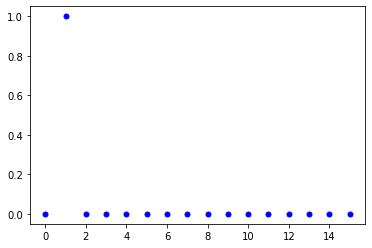

In [98]:
plt.plot(scipy.linalg.eig(rho, right=False), 'b.', markersize=10)

In [111]:
quantum_fisher_info(rho, Sx_matrix(p, 0, state_table).toarray())

(0.4396391564162815-6.917040059638622e-18j)

In [112]:
quantum_fisher_info(rho, Sx_matrix(p, 0, state_table).toarray())

(0.4396391564162815-6.917040059638622e-18j)

In [217]:
L = build_LindbladMatrix(p)
eigenvalues = scipy.linalg.eig(L.toarray(), right=False)

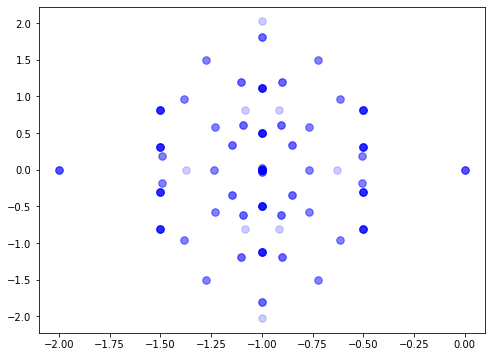

In [220]:
plt.figure(figsize=(8,6))
plt.plot(np.real(eigenvalues), np.imag(eigenvalues), 'b.', markersize=15, alpha=0.2)

In [ ]:
## do exact evolution
tic = time.time()
flat_initial_state = [item for sub in initial_state for item in sub]
# I think the definition of 0 and 1 is reversed (for me Z|0> = |0>) so I flip the initial state
# flat_initial_state = [1 - f for f in flat_initial_state]
sim, state_table = evolve(p, state_table, flat_initial_state, kind="list", trotterised=True)
toc = time.time()
print("Exact evolution took ", toc-tic, "s")

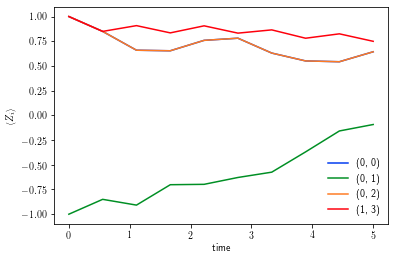

In [250]:
# plot
fig = plt.figure()
qubits = [(0, 0), (0, 1), (0, 2), (1, 3)]
for i, q in enumerate(qubits):
    site = p['W']*q[0]+q[1]
    # plt.plot(times, result[:, q[0], q[1]], label='{}'.format(q), color=colors[i])
    # Z measurement
    plt.plot(sim['Time'], sim['Zi Site {}'.format(site)], label='{}'.format(q), color=colours[i])
    # computational basis measurement
    # plt.plot(sim['Time'], 0.5*(1 - sim['Zi Site {}'.format(site)]), label='{}'.format(q), color=colours[i])
plt.xlabel('time')
plt.ylabel(r'$\langle Z_{i} \rangle$')
plt.legend();